In [ ]:
# Decision Tree Classifier
import numpy as np
from collections import Counter

In [8]:
# Gini Impurity
def gini(y):
    m = len(y)
    if m == 0:
        return 0
    counts = Counter(y)
    return 1 - sum((count/m)**2 for count in counts.values())

In [4]:
# Split dataset based on feature and threshold
def split(X, y, feature_idx, threshold):
    left_mask = X[:, feature_idx] <= threshold #vectore with true and false
    right_mask = ~left_mask # "~" bitwise NOT operator in numpy
    return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

In [5]:
# Node class
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None): # "*" after this we have to give keyword for assigning value
        self.feature = feature # Feature index to split on
        self.threshold = threshold 
        self.left = left
        self.right = right
        self.value = value # Class label if leaf node

    def is_leaf(self):
        return self.value is not None

In [16]:
# Implementation
class DecisionTree:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y, depth=0)

    def _grow_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        num_labels = len(set(y)) 

        # Stop conditions
        if (depth >= self.max_depth) or (num_labels == 1) or (num_samples == 0):
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)
        
        # Find the best split
        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)
        
        # Grow children
        X_left, y_left, X_right, y_right = split(X, y, best_feature, best_threshold)
        left_child = self._grow_tree(X_left, y_left, depth+1)
        right_child = self._grow_tree(X_right, y_right, depth+1)
        return Node(best_feature, best_threshold, left_child, right_child)
    
    def _best_split(self, X, y):
        m, n = X.shape
        best_gini = 1.0
        best_idx, best_threshold = None , None

        for feature_idx in range(n):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                X_left, y_left, X_right,  y_right = split(X, y, feature_idx, threshold)
                if len(y_left) == 0 or len(y_right) == 0:
                    continue # no gain, one side should not be empty

                g = (len(y_left)/m) * gini(y_left) + (len(y_right)/m) * gini(y_right) # combined gini of split. which should be smaller than gini of parents
                if g < best_gini:
                    best_gini = g
                    best_idx = feature_idx
                    best_threshold = threshold
        return best_idx, best_threshold
    
    def predict(self, X):
        return np.array([self._predict(inputs, self.root) for inputs in X])
    
    def _predict(self, inputs, node):
        if node.is_leaf():
            return node.value
        if inputs[node.feature] <= node.threshold:
            return self._predict(inputs, node.left)
        else:
            return self._predict(inputs, node.right)


In [17]:
# Testing
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Generating dataset
X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_redundant=0, random_state=40)

# Fitting the tree
tree = DecisionTree(max_depth=3)
tree.fit(X, y)
y_pred = tree.predict(X)

# Accuracy
acc = np.mean(y_pred == y)
print("Accuracy of our model: ", acc)

Accuracy of our model:  0.97


In [11]:
# Comparision with sklearn
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=3, random_state=40)
clf.fit(X, y)
sk_y_pred  = clf.predict(X)

print("Accuracy of sklearn: ", np.mean(sk_y_pred == y))

Accuracy of sklearn:  0.97


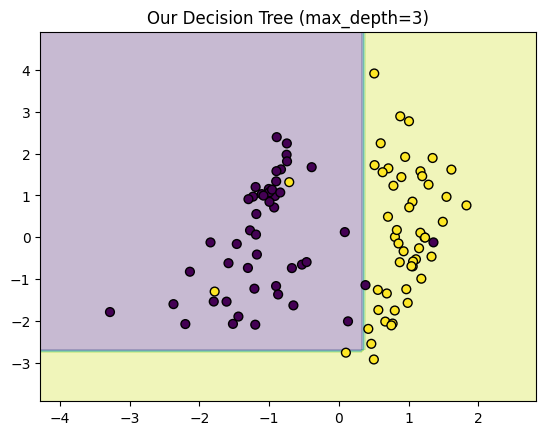

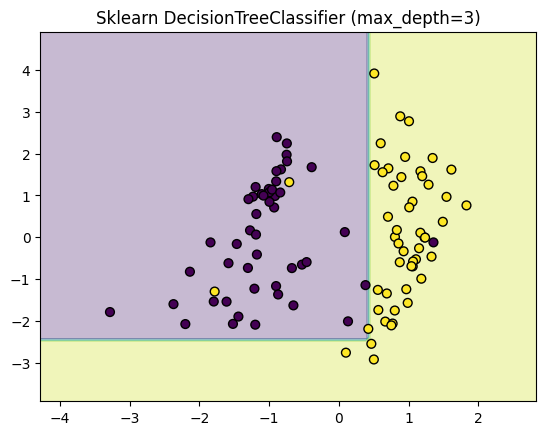

In [21]:
# Plot
# Function to plot decision boundary
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict for each point in the grid
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    # Plot
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="viridis")
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", edgecolor="k", s=40)
    plt.title(title)
    plt.show()

# Plot for our implementation
plot_decision_boundary(tree, X, y, "Our Decision Tree (max_depth=3)")

# Plot for sklearn's implementation
plot_decision_boundary(clf, X, y, "Sklearn DecisionTreeClassifier (max_depth=3)")
